In [15]:
# show matplotlin inline without anomation
%matplotlib inline

import sys
sys.path.append("../")

import yaml
import matplotlib.pyplot as plt
import cattrs
import numpy as np
from typing import List
#from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict
from mixture_optimization.datamodels.trial_tracking_config import Experiment, ValResult, Dict
from collections import defaultdict

from law import read_experiments, parse_results, fit, optimize

In [16]:
def visualize_per_domain_fitting(results: List[Dict], best_parameters: List[Dict], fitting_function):
    assert len(results[0]["results"].keys()) == 2, "Plotting only works in 2D"
    # create 3 subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

    labels = [f"{result['tokens_seen'] // 1_000_000}M" for result in results]
    lines = []

    for i, result in enumerate(results):
        key1 = list(result["results"].keys())[0]
        key2 = list(result["results"].keys())[1]

        weight1 =  [r["weight"] for r in result["results"][key1]]
        weight2 = [r["weight"] for r in result["results"][key2]]
        res1 = [r["perplexity"] for r in result["results"][key1]]
        res2 = [r["perplexity"] for r in result["results"][key2]]
        
        x = np.linspace(0, 1, 100)
        res1_fit = [fitting_function(x, *best_parameters[i][key1]) for x in x]
        res2_fit = [fitting_function(x, *best_parameters[i][key2]) for x in x]

        # plot 2
        axs[0].scatter(weight1, res1)
        line = axs[0].plot(x, res1_fit, '--')
        lines.append(line)
        axs[0].set_xlabel(f'Mixing Weight {key1}')
        axs[0].set_ylabel(f'{key1} Perplexity')
        axs[0].set_yscale('log')

        # plot 3
        axs[1].scatter(weight2, res2)
        axs[1].plot(x, res2_fit, '--')
        axs[1].set_xlabel(f'Mixing Weight {key2}')
        axs[1].set_ylabel(f'{key2} Perplexity')
        axs[1].set_yscale('log')

    # add legend centered over all plots
    fig.legend(lines, labels, loc='upper center', ncol=len(labels))


def visualize_weighted_2d(results: List[Dict], best_parameters: List[Dict], fitting_function):
    assert len(results[0]["results"].keys()) == 2, "Plotting only works in 2D"

    fig, ax = plt.subplots(figsize=(7, 5))
    labels = [f"{result['tokens_seen'] // 1_000_000}M" for result in results]
    lines = []

    # print true points
    for result in results:
        key1 = list(result["results"].keys())[0]
        key2 = list(result["results"].keys())[1]
        weights = [r["weight"] for r in result["results"][key1]]
        weighted_perplexity = [0.5 * (x1["perplexity"] + x2["perplexity"]) for x1, x2 in zip(result["results"][key1], result["results"][key2])]
        line = ax.scatter(weights, weighted_perplexity)
        lines.append(line)
        ax.set_title("Weighted perplexity")
        ax.set_xlabel(f"Mixing weight for {key1}")
        ax.set_ylabel(f"Weighted perplexity")
    
    # print fit
    
    for best_parameter in best_parameters:
        def weighted_sum_func(domain_weights: List[float]):
            sum = 0
            for domain_weight, domain_parameters in zip(domain_weights, best_parameter.values()):
                sum += fitting_function(domain_weight, *domain_parameters)
            sum /= len(domain_weights)
            return sum
        
        x = np.linspace(0, 1, 100)
        y = [weighted_sum_func([x1, 1-x1]) for x1 in x]
        ax.plot(x, y, '--')
    
    # add legend centered over all plots
    fig.legend(lines, labels, loc='upper center', ncol=len(labels))


def visualize_without_fitting(results, experiment: Experiment):
    # create 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=False)

    # preprocessing
    trial0 = experiment.trials[0]
    assert len(trial0.val_results.keys()) == 2, "Plotting only works in 2D"


    labels = [f"{result['tokens_seen'] // 1_000_000}M" for result in results]
    lines = []

    for result in results:
        key1 = list(result["results"].keys())[0]
        key2 = list(result["results"].keys())[1]

        weight1 =  [r["weight"] for r in result["results"][key1]]
        weight2 = [r["weight"] for r in result["results"][key2]]
        res1 = [r["perplexity"] for r in result["results"][key1]]
        res2 = [r["perplexity"] for r in result["results"][key2]]
        res = [0.5 * (x1 + x2) for x1, x2 in zip(res1, res2)]
        # plot 1
        line, = axs[0].plot(weight1, res, '-o')
        lines.append(line)
        axs[0].set_xlabel(f'Mixing Weight {key1}')
        axs[0].set_ylabel('Weighted Perplexity')

        # plot 2
        axs[1].plot(weight1, res1,'-o')
        axs[1].set_xlabel(f'Mixing Weight {key1}')
        axs[1].set_ylabel(f'{key1} Perplexity')
        axs[1].set_yscale('log')

        # plot 3
        axs[2].plot(weight2, res2, '-o')
        axs[2].set_xlabel(f'Mixing Weight {key2}')
        axs[2].set_ylabel(f'{key2} Perplexity')
        axs[2].set_yscale('log')

    # add legend centered over all plots
    fig.legend(lines, labels, loc='upper center', ncol=len(labels))

In [17]:
path = "/root/code/mixture_optimization/logs/lin_interp_books_c4_more_checkpoints_0/experiment_history.yaml"
experiments = read_experiments(path)
experiment = experiments[0]
no_evals = len(experiment.trials[0].all_results)

all_results = []
for i in range(no_evals):
    results = parse_results(experiment, i)
    all_results.append(results)

# Original results without fitting

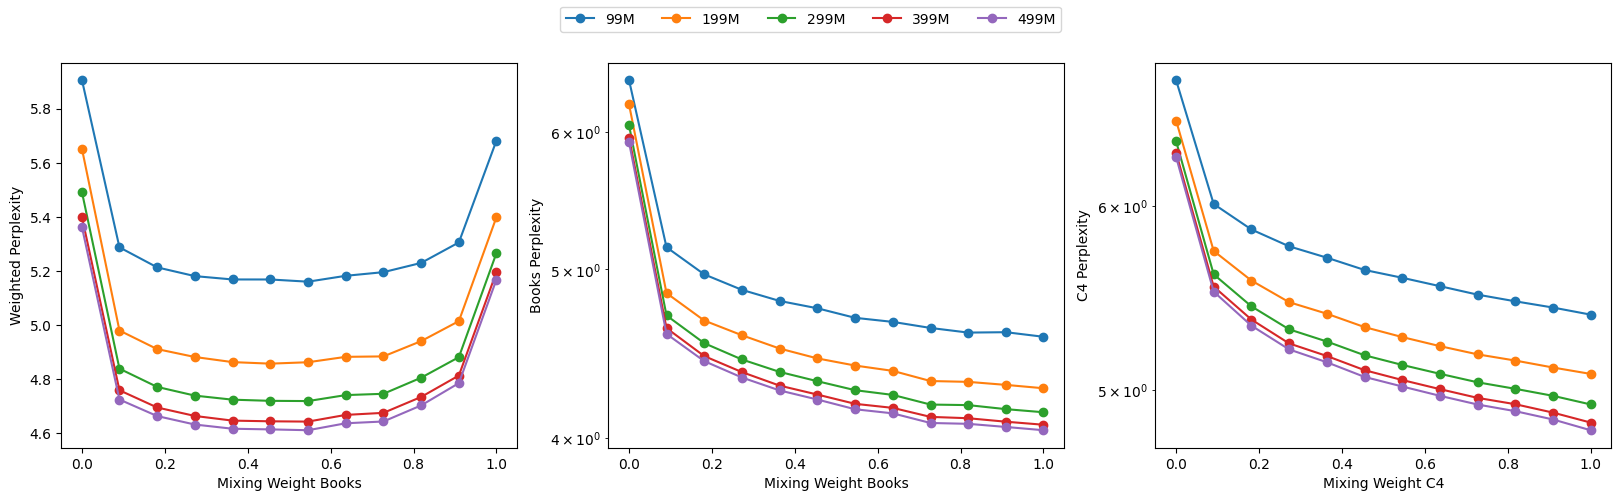

In [18]:
visualize_without_fitting(all_results, experiment)

# Fit each domain individually

/tmp/ipykernel_804850/2930008778.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return B/ (r**b)
/tmp/ipykernel_804850/2626253522.py:38: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(lines, labels, loc='upper center', ncol=len(labels))


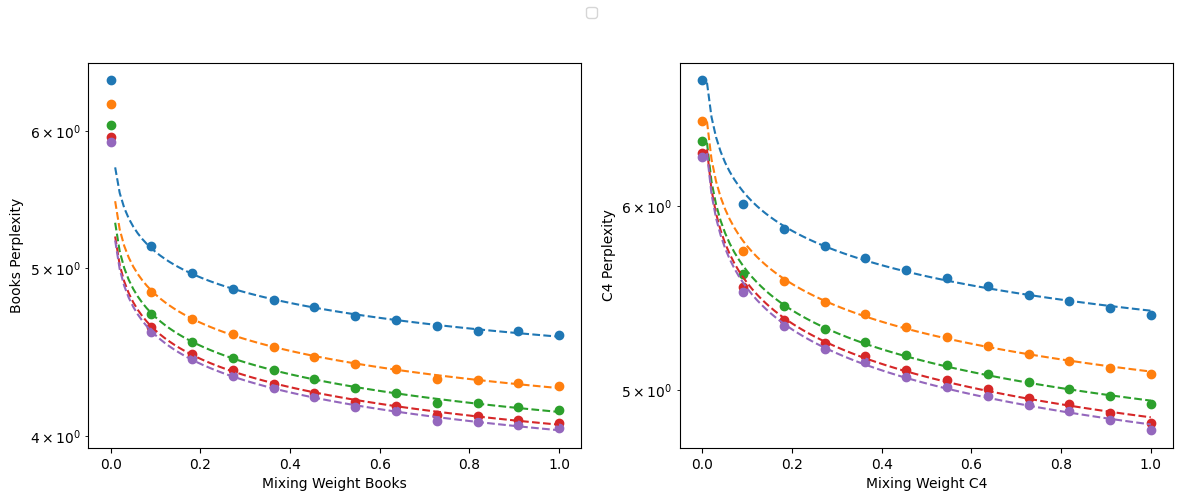

In [19]:
def func1(r, B, b):
    return B/ (r**b)

def func2(r, c, k , t):
    return c + k * np.exp(t * r)

func = func1

all_results = []
all_best_parameters = []

for idx in range(no_evals):
    best_parameters, results = fit(experiment, func, region=(0.1, 1), eval_idx=idx)
    all_results.append(results)
    all_best_parameters.append(best_parameters)

visualize_per_domain_fitting(all_results, all_best_parameters, func)

Using function1, we cannot quite fit the zero, as we would divide by zero here

# Weighted fit over all domains

Eval idx: 0. Best weights: [0.45993749 0.54006251]. Predicted value: 5.158069004810474
Eval idx: 1. Best weights: [0.45986435 0.54013565]. Predicted value: 4.855114082133804
Eval idx: 2. Best weights: [0.45456421 0.54543579]. Predicted value: 4.714976153161922
Eval idx: 3. Best weights: [0.44386757 0.55613243]. Predicted value: 4.639568037870894
Eval idx: 4. Best weights: [0.4428632 0.5571368]. Predicted value: 4.608201265843272


/tmp/ipykernel_804850/2930008778.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return B/ (r**b)


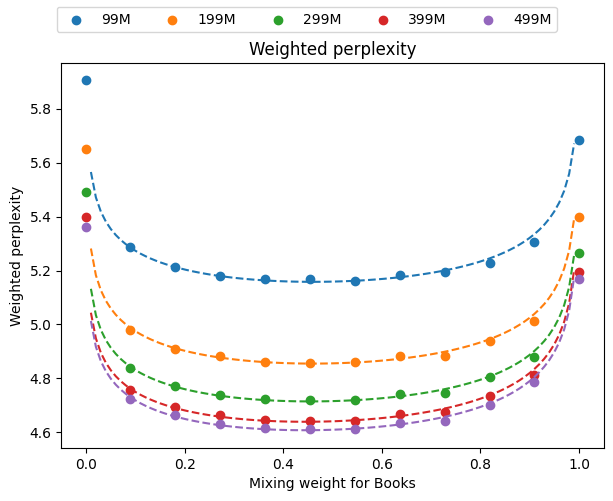

In [20]:
for idx in range(no_evals):
    best_parameters = all_best_parameters[idx]
    best_weights, pred_value = optimize(func, best_parameters)
    print(f"Eval idx: {idx}. Best weights: {best_weights}. Predicted value: {pred_value}")


visualize_weighted_2d(all_results, all_best_parameters, func)